## Normalization of wavelet transform

Using wavelet transform as-is on the landmark coordinates as pre processing before the autoencoder creates some issues, probably 
because of the highly lopsided and not normal distribution of wavelet powers. 
one possible way to deal with that is applying logarithm to the 
transformed data, data = np.log(data + k), where k is a parameter that prevents very small numbers in 'data' from approaching -inf.

Another way might be to divide the wavelet-transformed features by the sum for each tiemstep, like in <b><i>"Mapping the stereotyped behaviour offreely moving fruit flies"</i></b> Appendix C, and using KL or JS Divergence as a distance metric in the autoencoder itself. it is still not clear it will solve the problem, though maybe combining these way will work better - divide by sum, apply log, and use KL divergence on Softmax of the input and output as distance metric.


In addition, we probably should rearrange the classes a bit: a WaveletDataset class that accepts some feature data and performs wavelet transformation on them.
It should accept a list of numpy arrays with the feature data, array for each video, and do normalization etc. on all of them, perform wavelet transform, and do some post proccessing such as log and divition by sum to create probability distribution.

In [2]:
import torch
from torch import utils
import pandas as pd
import numpy as np
from pathlib import Path 
from matplotlib import pyplot as plt
from deep_cluster.dataloader import *
pd.set_option('mode.chained_assignment', None)

import os
import re
import numpy as np
import scipy.signal as sig
import pandas as pd

# root directory of data
data_root = Path("/home/orel/Storage/Data/K6/")
landmark_files = []
for subdir in os.listdir(data_root):
    for file in os.listdir(data_root/subdir/'Down'):
        if re.match(r"00\d*DeepCut_resnet50_Down2May25shuffle1_1030000\.h5", file):
            lfile = data_root/subdir/'Down'/file
            landmark_files.append(lfile)

here we check the response of the wavelet transform to pure sine waves, seeing that they should be normalized by the square root of the wavelet widths, in order to have equal responses.
see https://royalsocietypublishing.org/doi/pdf/10.1098/rsif.2014.0672 appendix C.

In [73]:
def calc_wavelet_transform(feature_data, min_width=12, max_width=120, n_waves=25):
    wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
    transformed = sig.cwt(feature_data, sig.morlet2, widths=wavelet_widths)
    transformed /= np.sqrt(wavelet_widths[:,np.newaxis])
#     import pdb; pdb.set_trace()
    return np.abs(transformed)

omega0 = 5
min_width=1; max_width=120; n_waves=25;
wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
wavelet_timescales = wavelet_widths / 60

wavelet_freqs = (omega0 + np.sqrt(2 + omega0**2)) / (4 * np.pi * wavelet_timescales)
T = 1000
sine_waves = np.exp(np.linspace(np.zeros_like(wavelet_freqs), 2j * T * np.pi * wavelet_freqs, 60*T))

transformed = np.stack([sig.cwt(sine_waves[:,i], sig.morlet2, widths=wavelet_widths[i:i+1]) for i in range(n_waves)])
c_s = (np.pi**(-1/4) / (np.sqrt(2 * wavelet_widths)) ) * np.exp(0.25 / (omega0 + np.sqrt(2 + omega0**2))**2)
np.abs(transformed).mean(axis=(1,2)) * c_s

array([0.99757587, 0.99757368, 0.9975707 , 0.99756569, 0.99756039,
       0.99755211, 0.99754449, 0.99753642, 0.99752381, 0.99751019,
       0.99749227, 0.99747104, 0.99744491, 0.99741315, 0.99737417,
       0.99732675, 0.99726884, 0.99719827, 0.99711193, 0.99700652,
       0.99687784, 0.99672071, 0.99652894, 0.9962949 , 0.99600911])

## TODO:  
Try using square root to normalize the wavelets, see how it affects  kurtosis and histogram.

In [12]:
def calc_wavelet_transform(feature_data, min_width=12, max_width=120, n_waves=25):
    wavelet_widths = np.logspace(np.log10(min_width), np.log10(max_width), n_waves)
    transformed = sig.cwt(feature_data, sig.morlet2, widths=wavelet_widths)
    transformed /= np.sqrt(wavelet_widths[:,np.newaxis])
    return np.abs(transformed)

# A dataset of landmarks
# args: landmarks file: .h5 file of landmarks, from DeepLabCut
class LandmarkWaveletDataset(utils.data.Dataset):
    def __init__(self, landmarks_file, normalize=True, data=None, eps=3e-2):
        super(LandmarkWaveletDataset, self).__init__()
        self.file = landmarks_file
        self.normalize = normalize
        self.landmarks = LandmarkDataset(self.file, normalize)
        if data is None:
            coords = sig.decimate(self.landmarks.coords, q=4, axis=0)
            coords = coords.reshape((len(coords), -1))
            self.data = [calc_wavelet_transform(feat_data, min_width=2, max_width=60, n_waves=20) for feat_data in coords.T]
            self.data = np.concatenate(self.data, axis=0).T
            self.data /= (self.data.sum(axis=0, keepdims=True) + 1e-8)
#             self.data = np.sqrt(self.data)
            self.data = np.log(self.data + 1e-6) + 12
        else:
            self.data = data
        
    def __getitem__(self, idx):
        if isinstance(idx, slice):
            return LandmarkWaveletDataset(self.file, self.normalize, data=self.data[idx])
        return self.data[idx]
    
    def __len__(self):
        return self.data.shape[0]


In [13]:
dsets = [LandmarkWaveletDataset(landmark_files[i]) for i in range(3)]

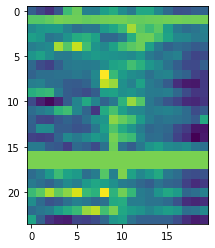

In [14]:
ds = dsets[0]
plt.imshow((ds.data / (ds.data.sum(axis=1, keepdims=True))).mean(axis=0).reshape(24, 20))

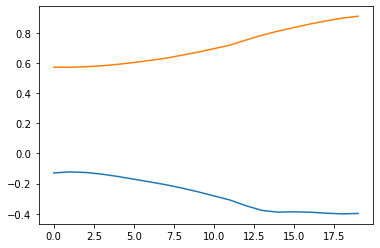

In [15]:
plt.plot(ds.data.mean(axis=0).reshape(24, 20).mean(axis=0))

plt.plot(ds.data.std(axis=0).reshape(24, 20).mean(axis=0))

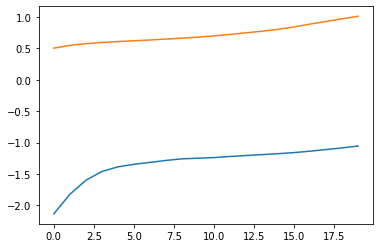

In [79]:
# with division by wavelet_width 

plt.plot(ds.data.mean(axis=0).reshape(24, 20).mean(axis=0))
plt.plot(ds.data.std(axis=0).reshape(24, 20).mean(axis=0))

1

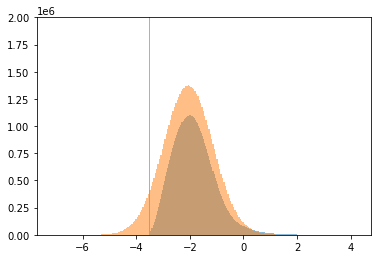

In [83]:
lg = False
plt.hist(ds.data.flatten(), bins=200, log=lg, alpha=0.5)
# plt.hist(np.random.laplace(loc=data.mean(), scale=np.abs(data-data.mean()).mean(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.hist(np.random.normal(loc=ds.data.mean(), scale=ds.data.std(), size=len(ds.data.flatten())), log=lg, alpha=0.5, bins=200)
plt.ylim((0, 2e6))
1

1

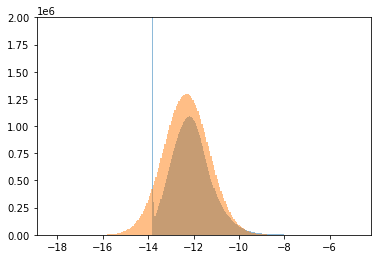

In [160]:
lg = False
plt.hist(data, bins=200, log=lg, alpha=0.5)
# plt.hist(np.random.laplace(loc=data.mean(), scale=np.abs(data-data.mean()).mean(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.hist(np.random.normal(loc=data.mean(), scale=data.std(), size=len(data.flatten())), log=lg, alpha=0.5, bins=200)
plt.ylim((0, 2e6))
1

(0.2546493009972952,
 0.40226192731401716,
 1.0062622614393086,
 -12.318450975144236)

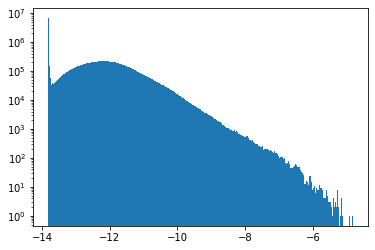

In [157]:
from scipy import stats
ds = dsets[-1]
data = ds.data / (ds.data.sum(axis=0) + 1e-7)
data = np.log(data.flatten()+1e-6)
plt.hist(data, bins=1000, log=True)
stats.kurtosis(data), stats.skew(data), data.std(), data.mean()

In [10]:
extract_coords(landmark_files[2])

array(['nose', 'neck', 'forepawR', 'forePawL', 'chest', 'belly',
       'hindpawR', 'hindpawL', 'tailbase', 'tail1', 'tail2', 'tail3'],
      dtype=object)